In [ ]:
# Bibliotecas python
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

In [ ]:
# Ferramentas do sklearn
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.inspection import permutation_importance

# On data

O projeto ondata tem como objetivo principal a criação de um sistema de gestão para sinistros relacionados à planos de saúde odontológicos. Para complementar o projeto com o uso de Machine Learning, dois modelos serão desenvolvidos:
- Um modelo de regressão que deve prever qual deve ser o custo do seguro para um cliente com base em métricas como idade, bmi, número de filhos, etc.
- Um modelo K-means de clusterização que classificará cada cliente à uma categoria de risco.

Após o treinamento e validação destes modelos, será criada uma API em Flask para que sejam realizadas predições on demand por outros serviços do projeto.

## Dataset

O dataset abaixo se trata de uma base de dados que possui as informações de custos de um plano de saúde baseado em algumas informações dos clientes, como idade, sexo, BMI, número de dependentes, tabagismo e região geográfica.

**Obs.** Estes custos estão relacionados a planos de saúde gerais, e não somente odontológicos. No entanto, todas as features representam características que também podem ser relevantes para um estudo de planos de saúde odontológicos. Caso possuíssimos um dataset específico de clientes da odontoprev, as mesmas técnicas também poderia ser aplicadas.

In [ ]:
df = pd.read_csv('https://raw.githubusercontent.com/stedy/Machine-Learning-with-R-datasets/master/insurance.csv')
print(df.shape)
df.head()

(1338, 7)


,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


In [ ]:
# Busca por valores nulos ou vazios
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB


In [ ]:
df.isnull().sum()

,0
age,0
sex,0
bmi,0
children,0
smoker,0
region,0
charges,0


In [ ]:
# Estatísticas gerais
df.describe()


,age,bmi,children,charges
count,1338.000000,1338.000000,1338.000000,1338.000000
mean,39.207025,30.663397,1.094918,13270.422265
std,14.049960,6.098187,1.205493,12110.011237
min,18.000000,15.960000,0.000000,1121.873900
25%,27.000000,26.296250,0.000000,4740.287150
50%,39.000000,30.400000,1.000000,9382.033000
75%,51.000000,34.693750,2.000000,16639.912515
max,64.000000,53.130000,5.000000,63770.428010


In [ ]:
# Variáveis não numéricas
for col in ['sex', 'smoker', 'region']:
    print(f"\n{col}:")
    display(df[col].value_counts())


sex:


,count
sex,
male,676
female,662



smoker:


,count
smoker,
no,1064
yes,274



region:


,count
region,
southeast,364
southwest,325
northwest,325
northeast,324


## Análise Exploratória

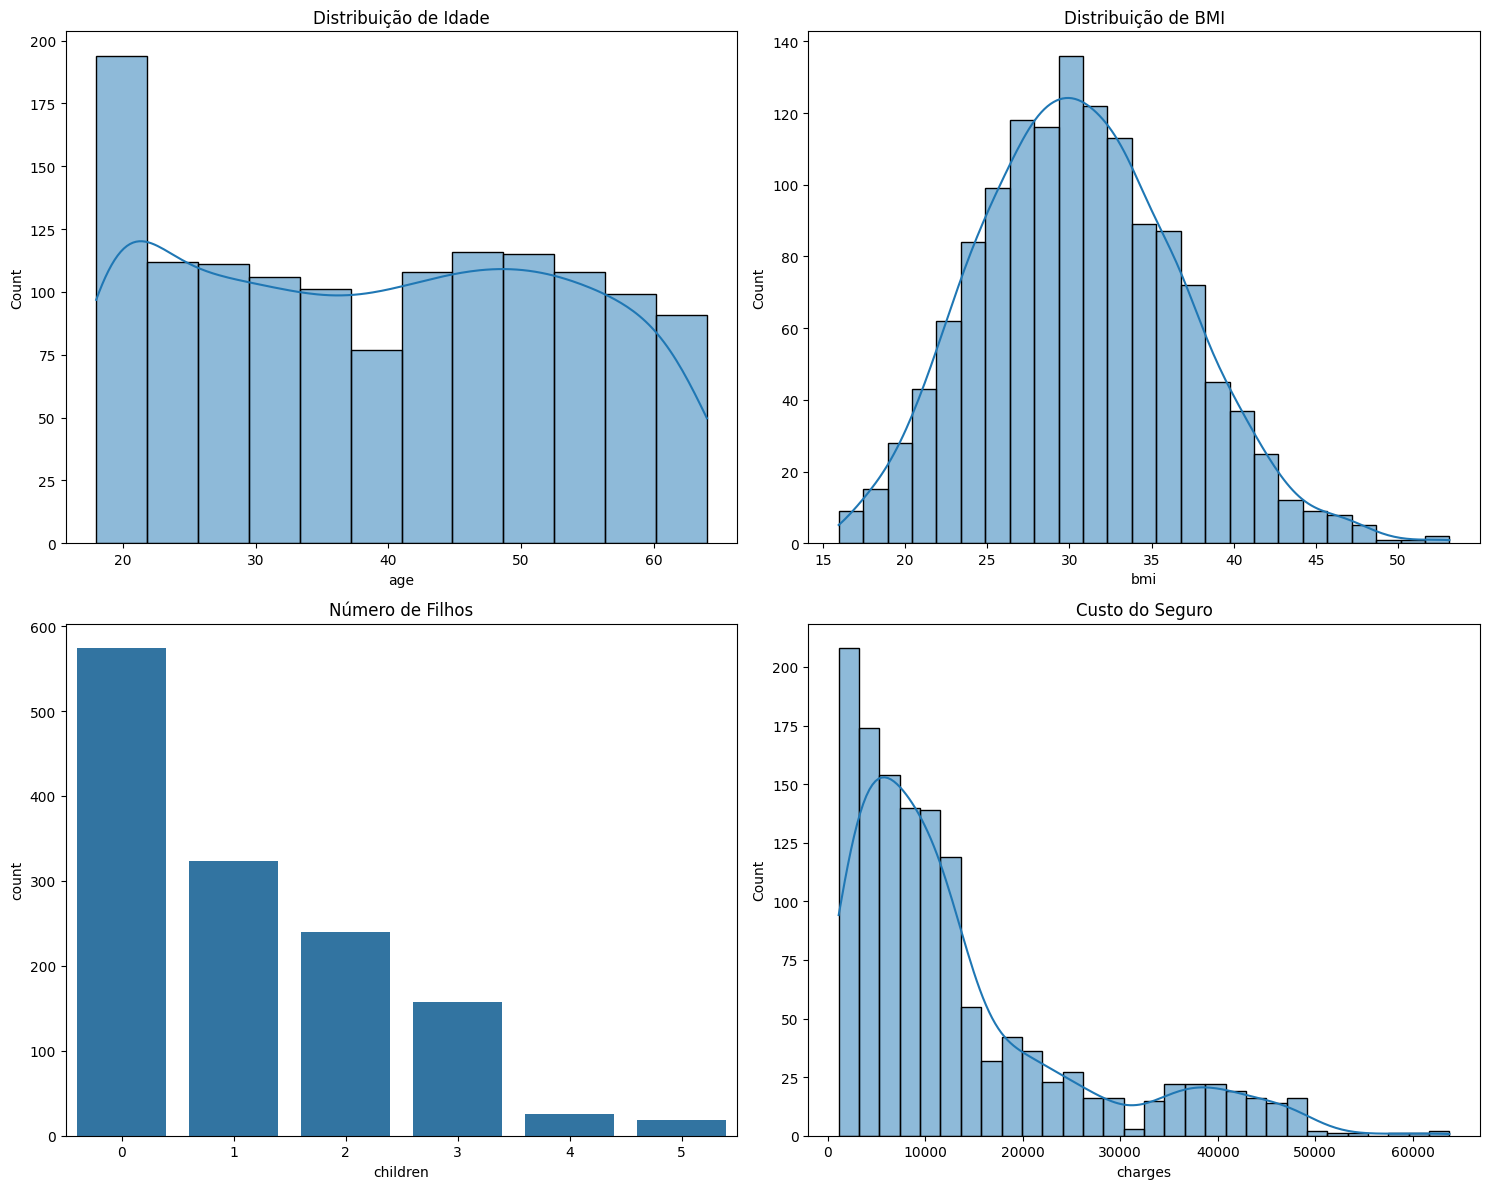

In [ ]:
# Histogramas para variáveis numéricas
plt.figure(figsize=(15, 12))

# Distribution of numerical variables
plt.subplot(2, 2, 1)
sns.histplot(df['age'], kde=True)
plt.title('Distribuição de Idade')

plt.subplot(2, 2, 2)
sns.histplot(df['bmi'], kde=True)
plt.title('Distribuição de BMI')

plt.subplot(2, 2, 3)
sns.countplot(x='children', data=df)
plt.title('Número de Filhos')

plt.subplot(2, 2, 4)
sns.histplot(df['charges'], kde=True)
plt.title('Custo do Seguro')

plt.tight_layout()
plt.show()

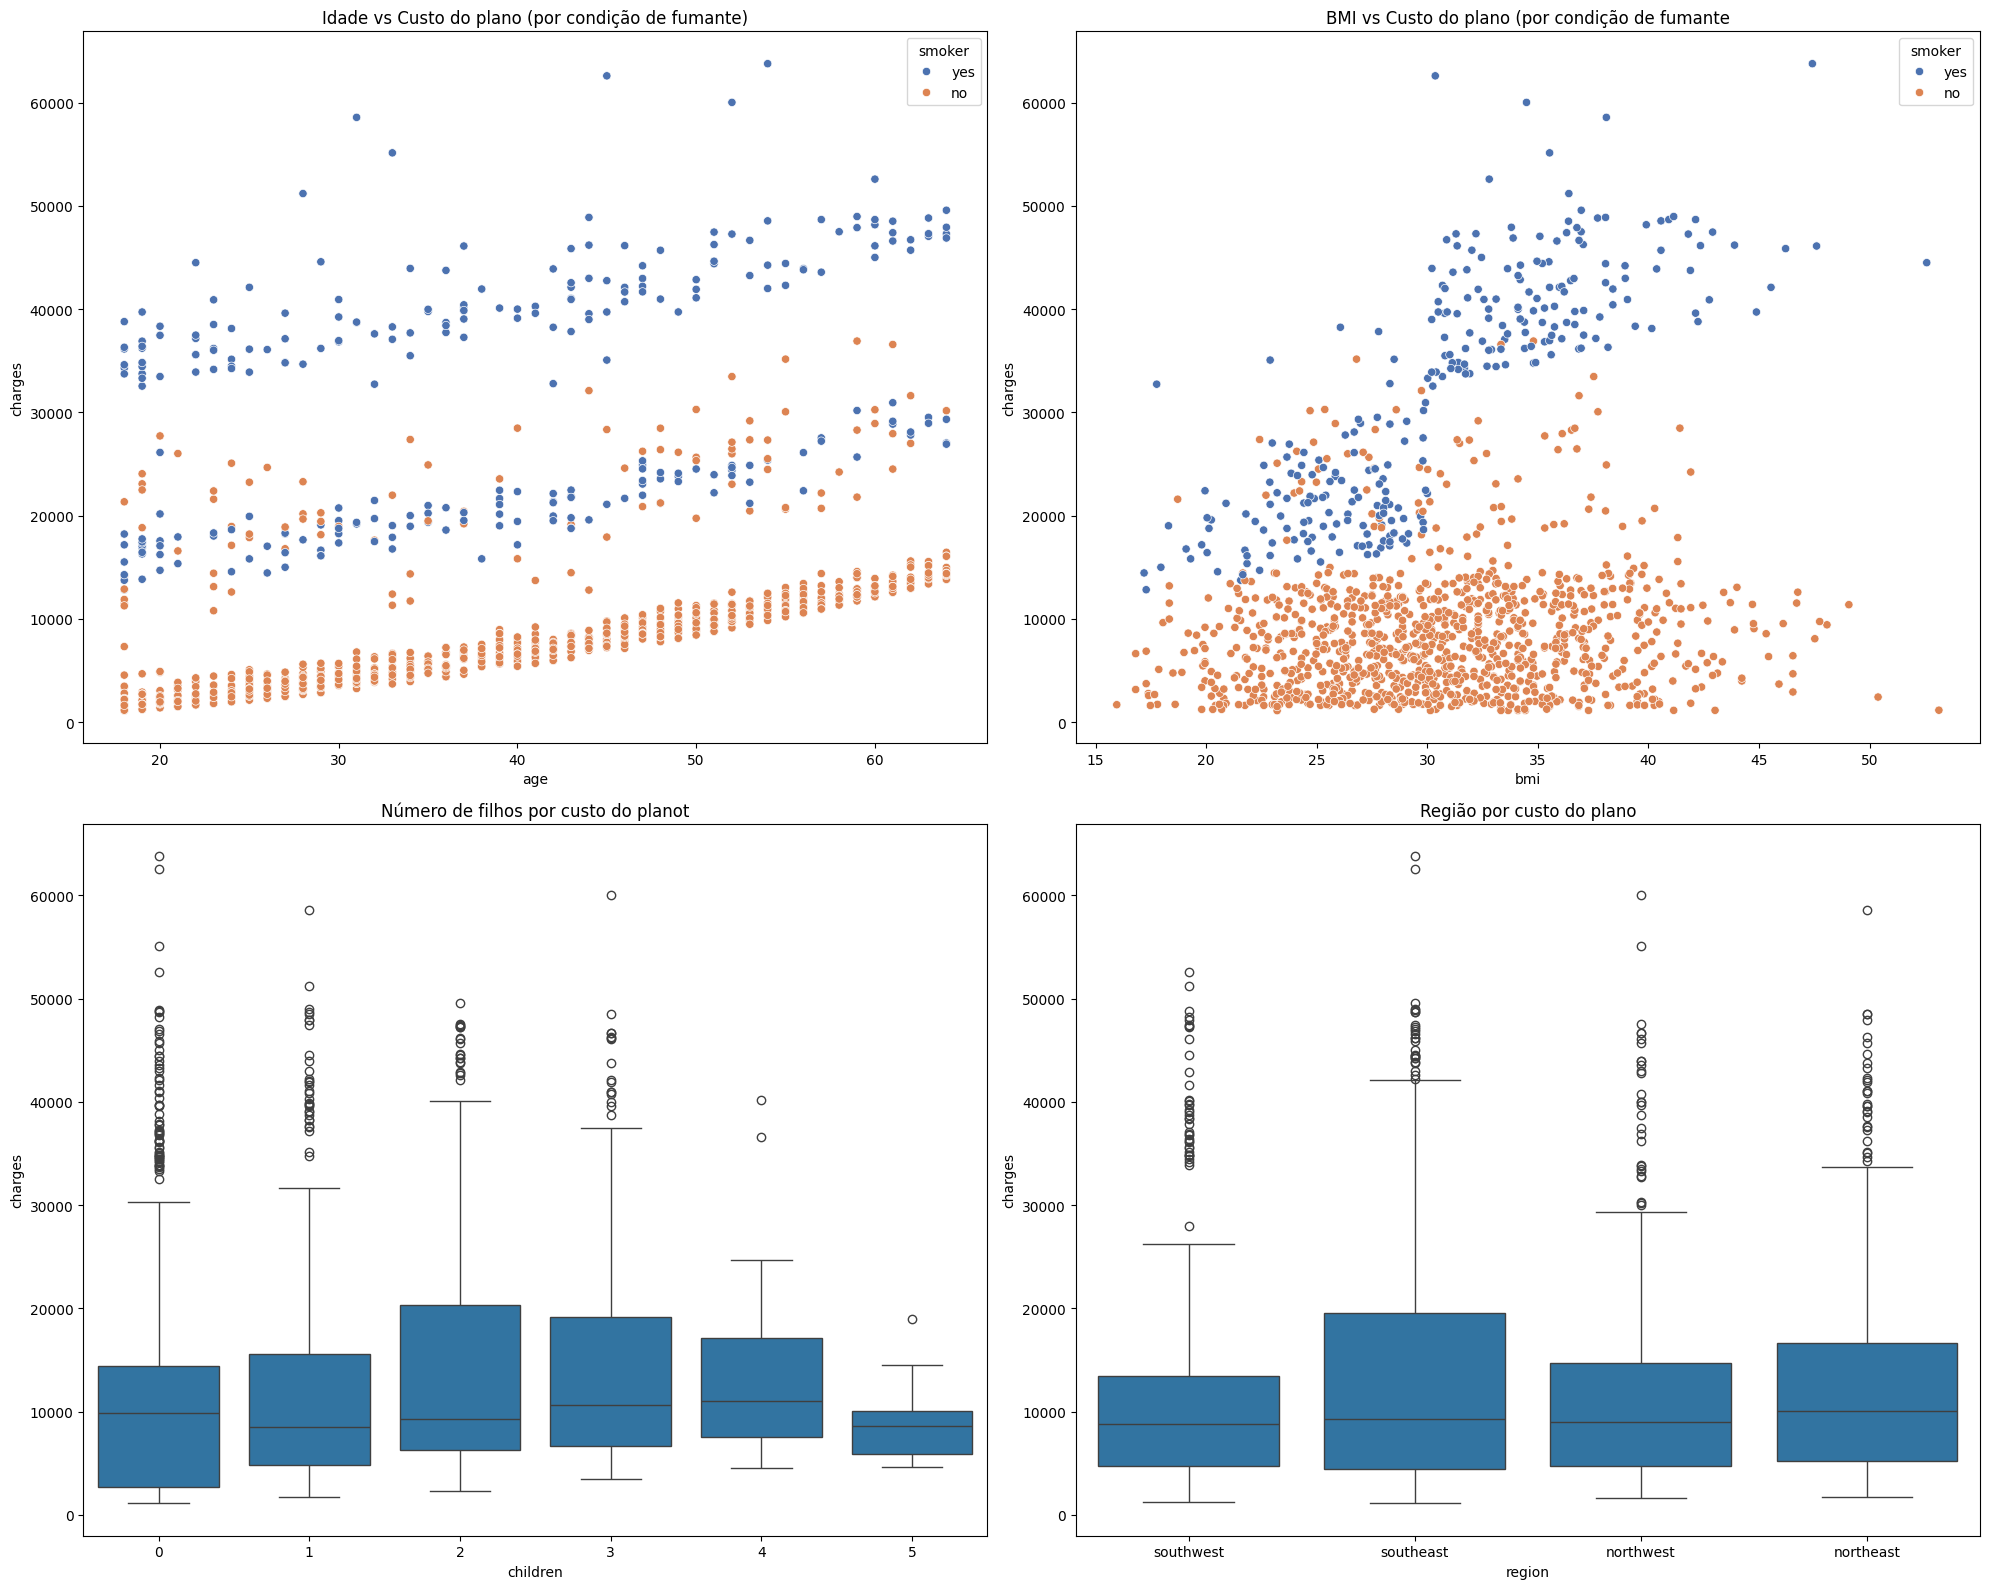

In [ ]:
# Relação entre Features e Target
plt.figure(figsize=(20, 16))

# Idade vs Custo do plano
plt.subplot(2, 2, 1)
sns.scatterplot(x='age', y='charges', hue='smoker', data=df, palette='deep')
plt.title('Idade vs Custo do plano (por condição de fumante)')

# BMI vs Custo do plano (por condição de fumante
plt.subplot(2, 2, 2)
sns.scatterplot(x='bmi', y='charges', hue='smoker', data=df, palette='deep')
plt.title('BMI vs Custo do plano (por condição de fumante')

# Número de filhos por custo do planot
plt.subplot(2, 2, 3)
sns.boxplot(x='children', y='charges', data=df)
plt.title('Número de filhos por custo do planot')

# Região por custo do plano
plt.subplot(2, 2, 4)
sns.boxplot(x='region', y='charges', data=df)
plt.title('Região por custo do plano')

plt.tight_layout()
plt.show()

Daqui podemos tirar algumas conclusões interessantes. Tanto no scatter plot da idade por custo e do bmi por custo, podemos ver uma correlação positiva entre os fatores (mais clara no gráfico de idade, e mais branda no gráfico de bmi), que é ainda mais exarcebada para pacientes fumantes. Além disso, pacientes fumantes no geral, independente de idade ou bmi, pagam mais caro do que um paciente não fumante nas mesmas condições.

Em relação aos box plots de número de filhos, podemos ver que o valor mínimo de custo de plano de saúde cresce ordenadamente quanto mairo é a quantidade de crianças de um cliente. Esse comportamente somente é quebrado para pais com 5 filhos. Isso pode ocorrer pela baixa amostra de pais com essa quantidade de filhos e por, provavelmente, o número de filhos não ser tão influentes quanto outros fatores para o custo do plano, como vamos ver a frente.

Em relação à região onde mora cada paciente, vemos que o valor base dos planos de saúde são os mesmos para todas as regiões. No entanto, o limite superior deste custo pode ser maior ou menor, a depender da região estudada.

Por estes motivos, nenhuma das variáveis representadas será removida do dataset.

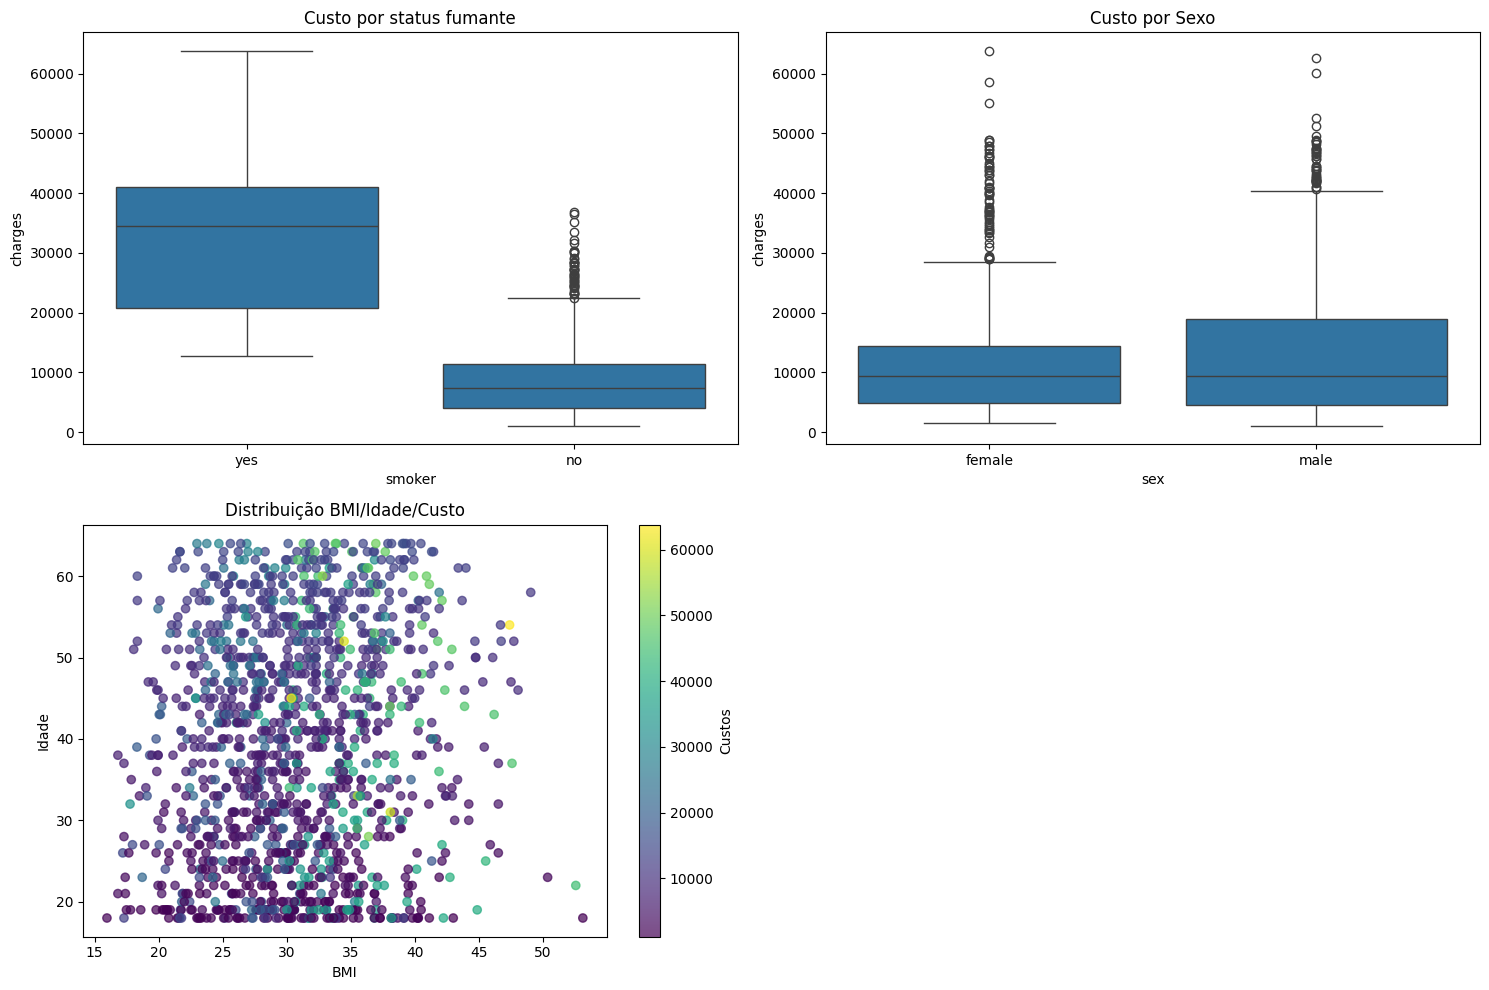

In [ ]:
# Mais relações
plt.figure(figsize=(15, 10))

plt.subplot(2, 2, 1)
sns.boxplot(x='smoker', y='charges', data=df)
plt.title('Custo por status fumante')

plt.subplot(2, 2, 2)
sns.boxplot(x='sex', y='charges', data=df)
plt.title('Custo por Sexo')


plt.subplot(2, 2, 3)
scatter = plt.scatter(df['bmi'], df['age'], c=df['charges'], cmap='viridis', alpha=0.7)
plt.colorbar(scatter, label='Custos')
plt.xlabel('BMI')
plt.ylabel('Idade')
plt.title('Distribuição BMI/Idade/Custo')

plt.tight_layout()
plt.show()

Nestas outras análises, observamos também que o custo médio e variância são maiores para clientes fumantes em relação à clientes não fumantes.
O extremo superior do custo de plano de saúde para homens é maior.
E existe uma sutil relção determinando que pessoas com o BMI muito alto, geralmente pagam mais em planos de saúde, principalmente quando mais velhas.

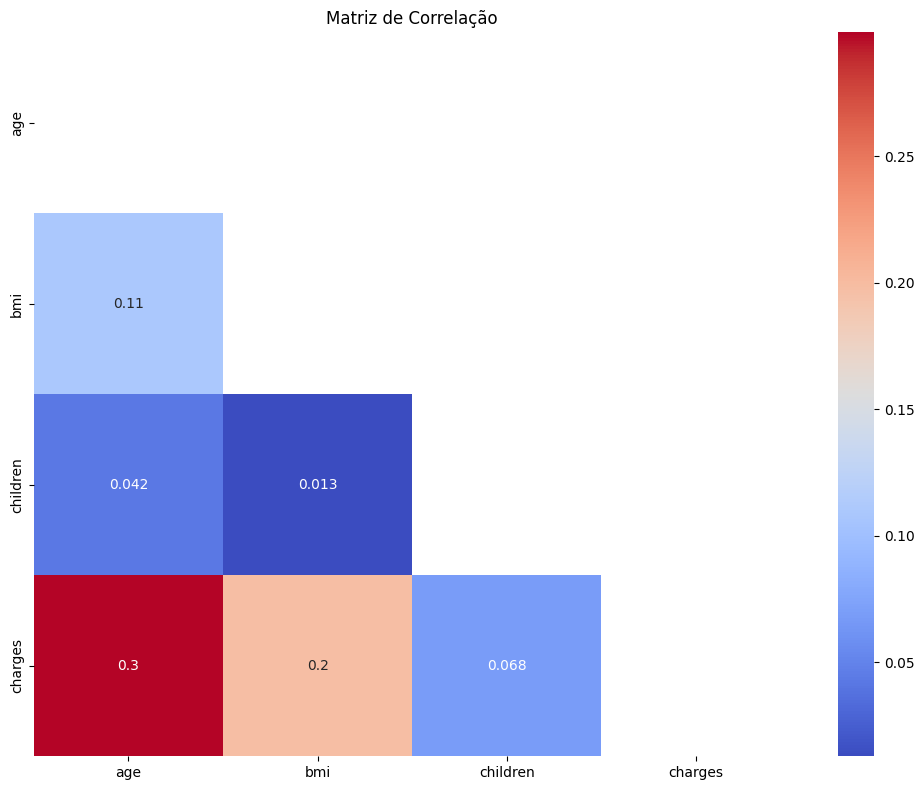

In [ ]:
# Matriz de Correlação
plt.figure(figsize=(10, 8))
numeric_df = df.select_dtypes(include=[np.number])
correlation = numeric_df.corr()
mask = np.triu(correlation)
sns.heatmap(correlation, annot=True, cmap='coolwarm', mask=mask)
plt.title('Matriz de Correlação')
plt.tight_layout()
plt.show()

Como colocado como hipótese anteriormente, é visível agora que o número de crianças, apesar de ter certa correlação com o valor do plano de saúde, não influencia de forma crítica nessa métrica.

## Manipulação das Features

In [ ]:
# cópia
df_processed = df.copy()

A condição de um paciente ser fumante, como visto durante a análise exploratória, é a feature que mais influencia no aumento do custo do plano de saúde de um paciente. Por conta disso, vamos criar algumas features combinando a condição de fumante com outra feature da base de dados, como forma de capturar melhor o impacto de um cliente ser fumante ou não no nosso modelo.

In [ ]:
# Criação de novas features para potencializar o fator fumante
df_processed['smoker_bmi'] = df_processed['bmi'] * df_processed['smoker'].map({'yes': 1, 'no': 0})
df_processed['smoker_age'] = df_processed['age'] * df_processed['smoker'].map({'yes': 1, 'no': 0})

df_processed.head()

,age,sex,bmi,children,smoker,region,charges,smoker_bmi,smoker_age
0,19,female,27.900,0,yes,southwest,16884.92400,27.9,19
1,18,male,33.770,1,no,southeast,1725.55230,0.0,0
2,28,male,33.000,3,no,southeast,4449.46200,0.0,0
3,33,male,22.705,0,no,northwest,21984.47061,0.0,0
4,32,male,28.880,0,no,northwest,3866.85520,0.0,0


## Preparação e Treinamento dos Modelos de Regressão

In [ ]:
df_model = df_processed.copy()

# Prepare features for regression
X = df_model.drop(['charges'], axis=1)
y = df_model['charges']

# Separação de variáveis categóricas e numéricas
categorical_cols = ['sex', 'smoker', 'region']
numerical_cols = ['age', 'bmi', 'children', 'smoker_bmi', 'smoker_age']

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_cols),
        ('cat', OneHotEncoder(drop='first'), categorical_cols)
    ]
)

# Separação dos dados
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [ ]:
# Função para avaliar modelos e plotar gráfico
def evaluate_model(model, X_train, X_test, y_train, y_test, model_name):
    pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('model', model)
    ])

    # Treino e predict
    pipeline.fit(X_train, y_train)

    y_pred = pipeline.predict(X_test)

    # Métricas de performance
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, y_pred)


    cv_scores = cross_val_score(pipeline, X, y, cv=5, scoring='r2')

    print(f"{model_name} Resultados:")
    print(f"MAE: ${mae:.2f}")
    print(f"MSE: ${mse:.2f}")
    print(f"RMSE: ${rmse:.2f}")
    print(f"R²: {r2:.4f}")
    print(f"Cross-validation R²: {np.mean(cv_scores):.4f} (±{np.std(cv_scores):.4f})")

    # Visualize predictions
    plt.figure(figsize=(10, 6))
    plt.scatter(y_test, y_pred, alpha=0.5)
    plt.plot([y.min(), y.max()], [y.min(), y.max()], 'r--')
    plt.xlabel('Actual Charges')
    plt.ylabel('Predicted Charges')
    plt.title(f'{model_name} - Actual vs Predicted Charges')
    plt.tight_layout()
    plt.show()

    return pipeline, mae, mse, rmse, r2, np.mean(cv_scores)


Linear Regression Resultados:
MAE: $2757.76
MSE: $20922607.94
RMSE: $4574.12
R²: 0.8652
Cross-validation R²: 0.8370 (±0.0315)


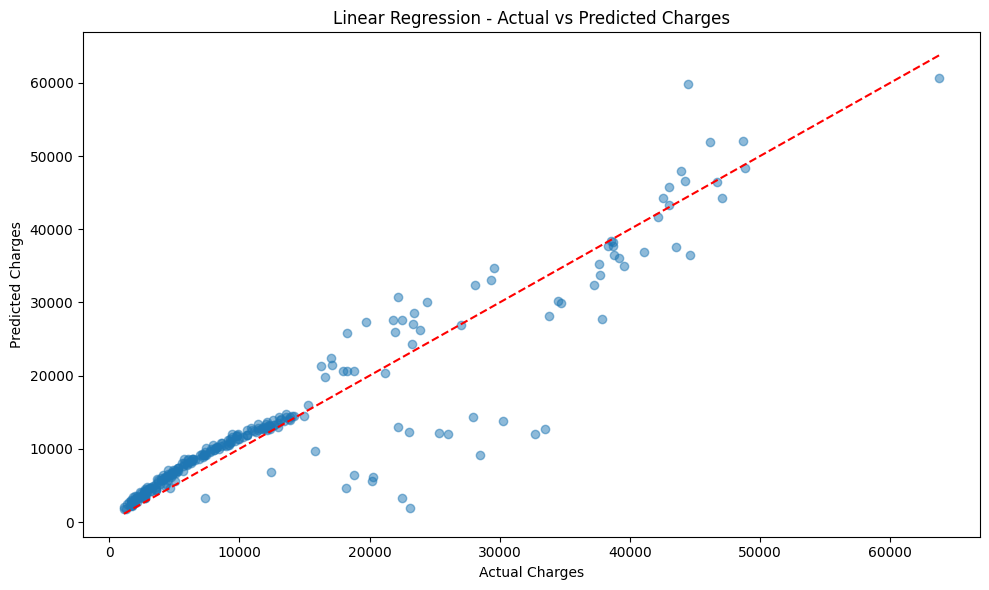

Ridge Regression Resultados:
MAE: $2935.88
MSE: $21692080.16
RMSE: $4657.48
R²: 0.8603
Cross-validation R²: 0.8279 (±0.0296)


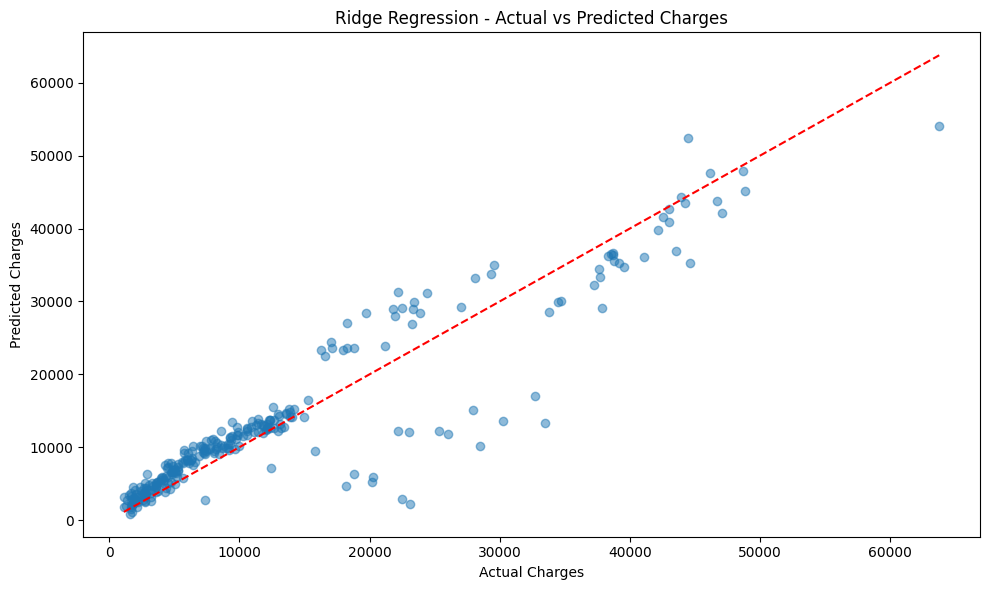

Lasso Regression Resultados:
MAE: $2776.10
MSE: $20865071.27
RMSE: $4567.83
R²: 0.8656
Cross-validation R²: 0.8368 (±0.0310)


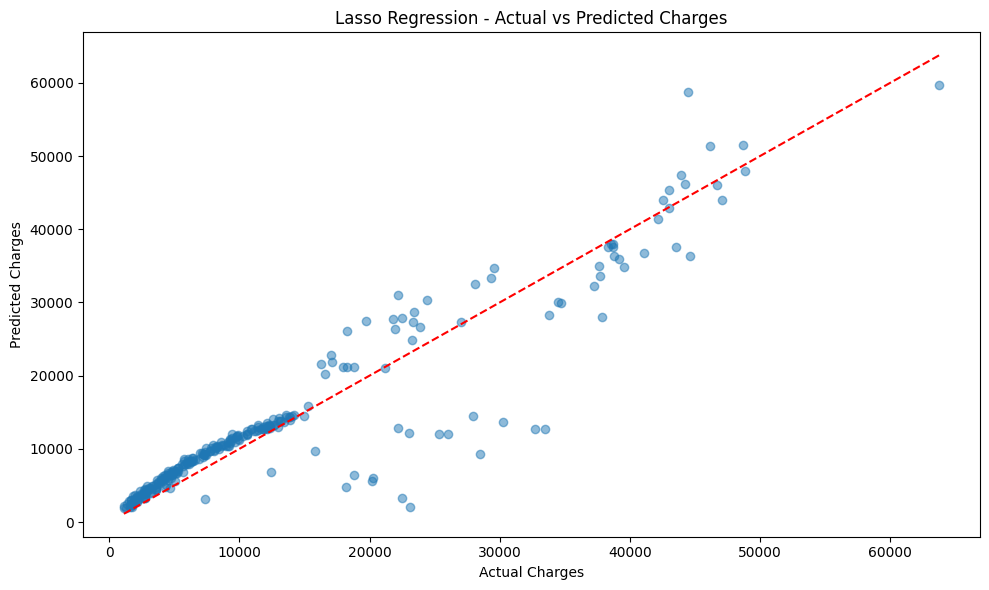

Random Forest Regression Resultados:
MAE: $2538.58
MSE: $20735626.62
RMSE: $4553.64
R²: 0.8664
Cross-validation R²: 0.8375 (±0.0309)


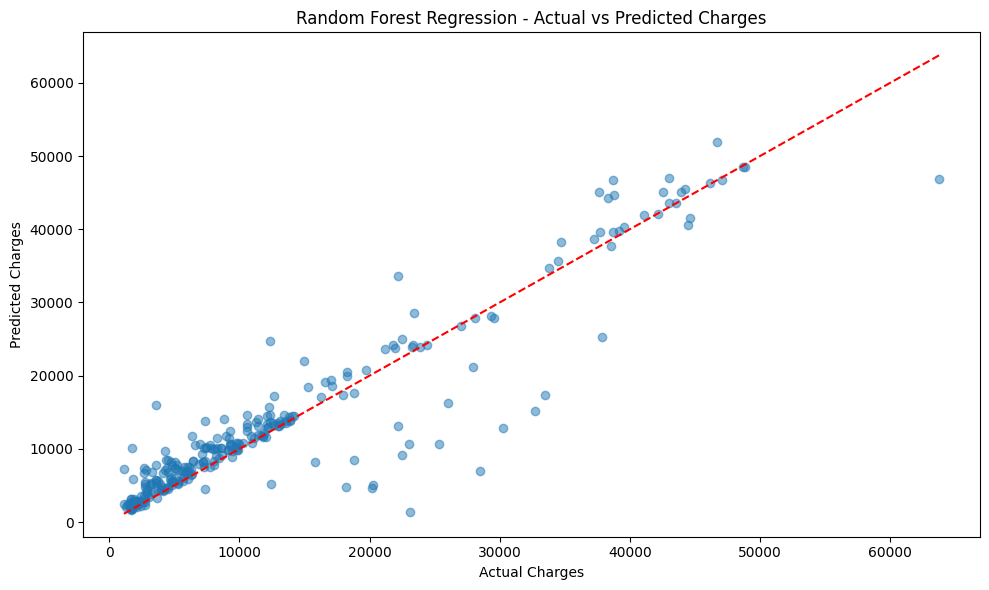

Gradient Boosting Regression Resultados:
MAE: $2477.66
MSE: $19070632.09
RMSE: $4366.99
R²: 0.8772
Cross-validation R²: 0.8535 (±0.0346)


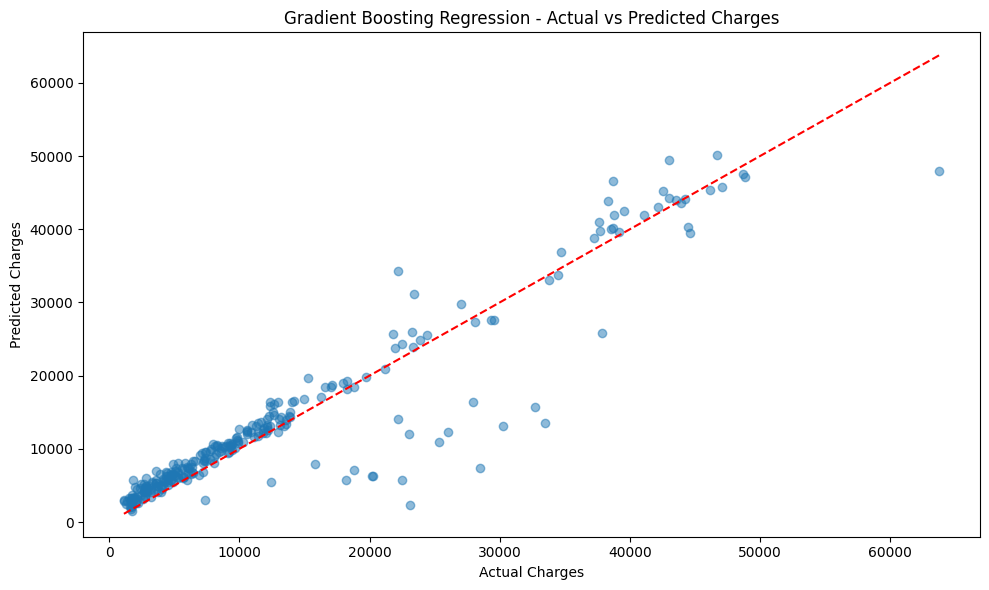

Support Vector Regression Resultados:
MAE: $4221.39
MSE: $74672575.27
RMSE: $8641.33
R²: 0.5190
Cross-validation R²: 0.4937 (±0.0177)


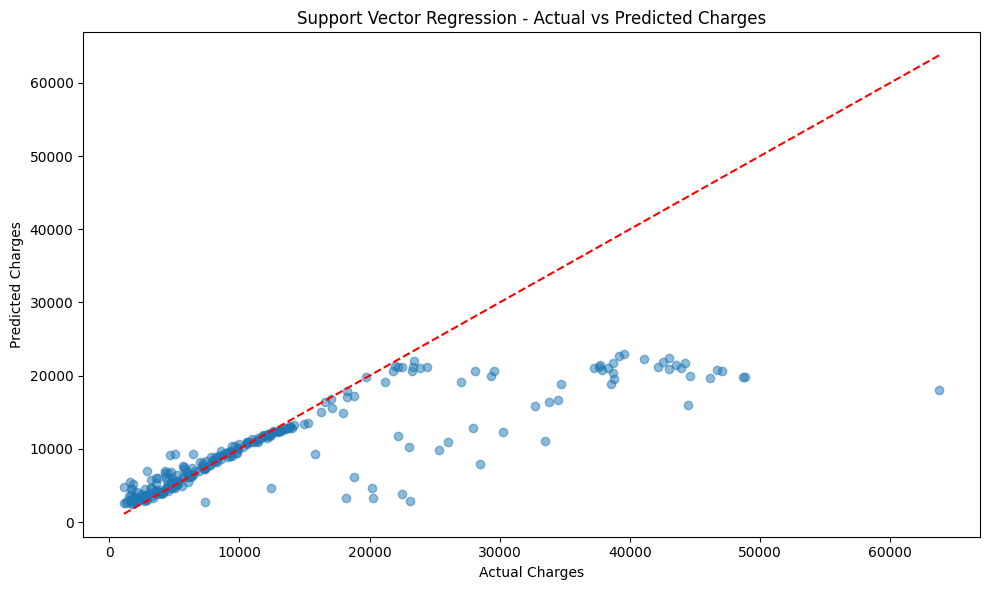

In [ ]:
# Regressão Linear
lr_model = LinearRegression()
lr_pipeline, lr_mae, lr_mse, lr_rmse, lr_r2, lr_cv = evaluate_model(
    lr_model, X_train, X_test, y_train, y_test, "Linear Regression"
)

# Regressão Ridge
ridge_model = Ridge(alpha=10.0)
ridge_pipeline, ridge_mae, ridge_mse, ridge_rmse, ridge_r2, ridge_cv = evaluate_model(
    ridge_model, X_train, X_test, y_train, y_test, "Ridge Regression"
)

# Regressão Lasso
lasso_model = Lasso(alpha=10.0)
lasso_pipeline, lasso_mae, lasso_mse, lasso_rmse, lasso_r2, lasso_cv = evaluate_model(
    lasso_model, X_train, X_test, y_train, y_test, "Lasso Regression"
)

# Regressão Random Forest
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_pipeline, rf_mae, rf_mse, rf_rmse, rf_r2, rf_cv = evaluate_model(
    rf_model, X_train, X_test, y_train, y_test, "Random Forest Regression"
)

# Regressão Gradient Boost
gb_model = GradientBoostingRegressor(n_estimators=100, random_state=42)
gb_pipeline, gb_mae, gb_mse, gb_rmse, gb_r2, gb_cv = evaluate_model(
    gb_model, X_train, X_test, y_train, y_test, "Gradient Boosting Regression"
)

# SVR (Support Vector Regression)
svr_model = SVR(kernel='rbf', C=100, gamma=0.1, epsilon=0.1)
svr_pipeline, svr_mae, svr_mse, svr_rmse, svr_r2, svr_cv = evaluate_model(
    svr_model, X_train, X_test, y_train, y_test, "Support Vector Regression"
)

## Comparação dos modelos

In [ ]:
models = ['Linear Regression', 'Ridge Regression', 'Lasso Regression',
          'Random Forest', 'Gradient Boosting', 'SVR']
mae_scores = [lr_mae, ridge_mae, lasso_mae, rf_mae, gb_mae, svr_mae]
rmse_scores = [lr_rmse, ridge_rmse, lasso_rmse, rf_rmse, gb_rmse, svr_rmse]
r2_scores = [lr_r2, ridge_r2, lasso_r2, rf_r2, gb_r2, svr_r2]
cv_scores = [lr_cv, ridge_cv, lasso_cv, rf_cv, gb_cv, svr_cv]


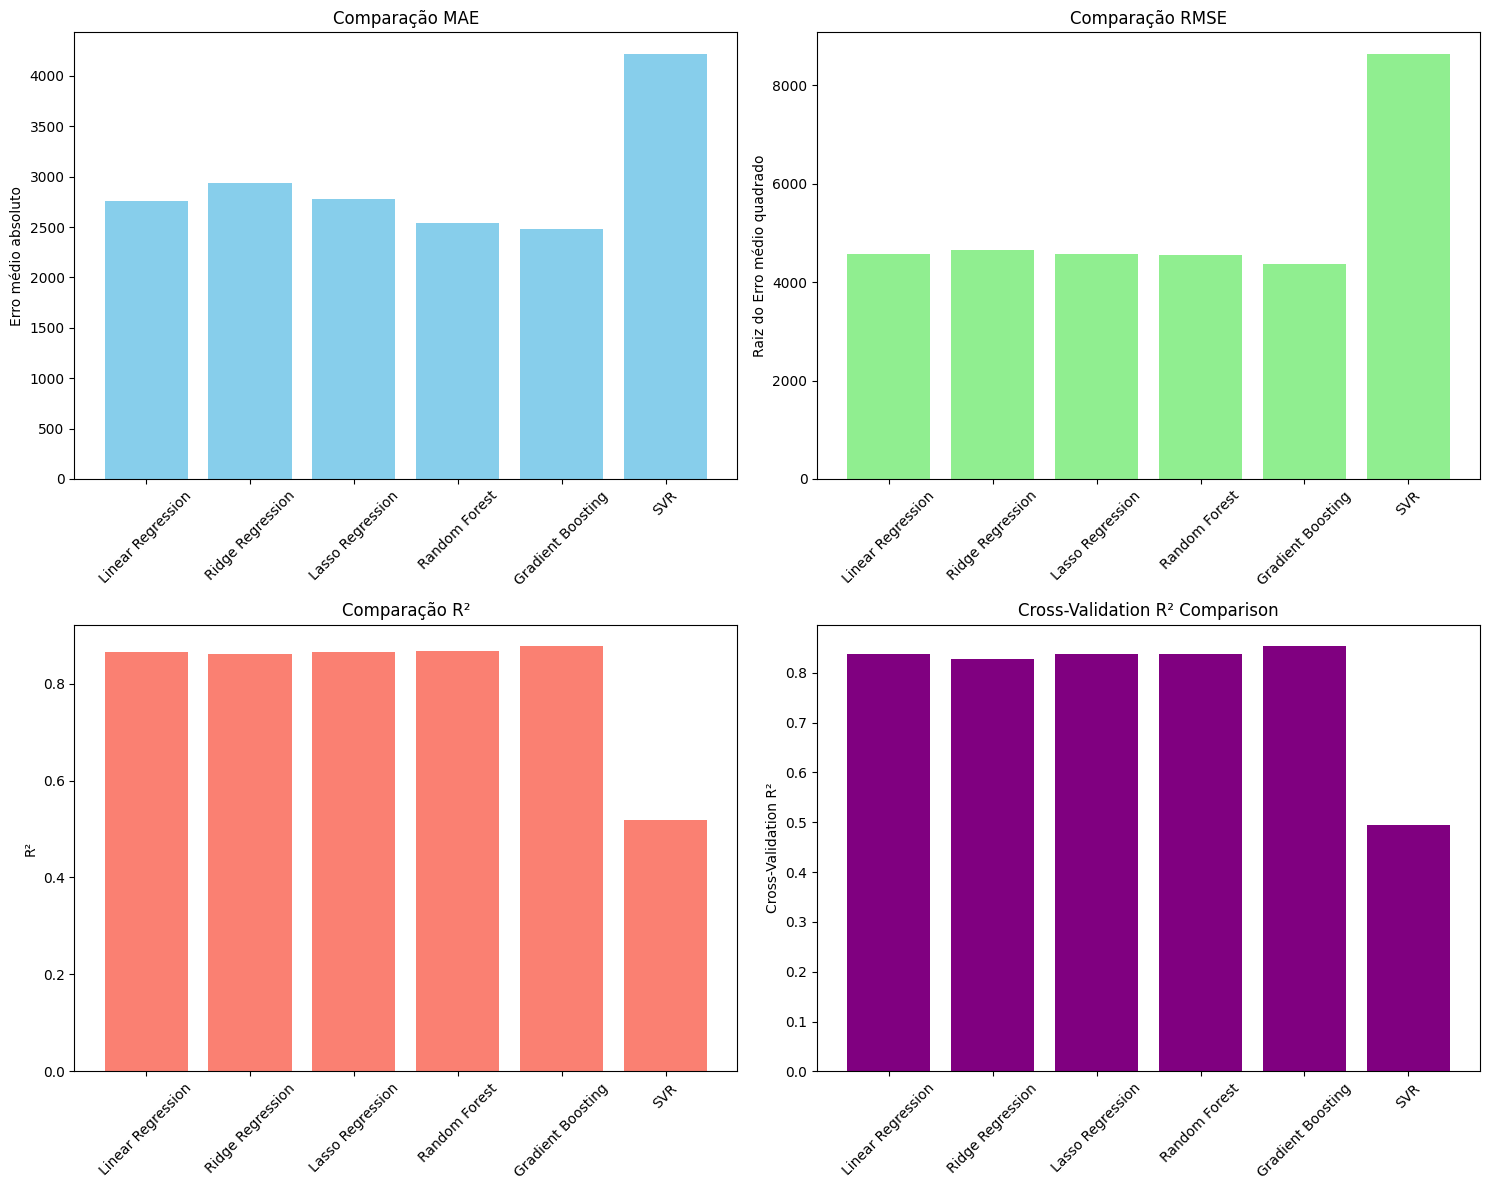

In [ ]:
# Plot
plt.figure(figsize=(15, 12))

plt.subplot(2, 2, 1)
plt.bar(models, mae_scores, color='skyblue')
plt.title('Comparação MAE')
plt.ylabel('Erro médio absoluto')
plt.xticks(rotation=45)

plt.subplot(2, 2, 2)
plt.bar(models, rmse_scores, color='lightgreen')
plt.title('Comparação RMSE')
plt.ylabel('Raiz do Erro médio quadrado')
plt.xticks(rotation=45)

plt.subplot(2, 2, 3)
plt.bar(models, r2_scores, color='salmon')
plt.title('Comparação R²')
plt.ylabel('R²')
plt.xticks(rotation=45)

plt.subplot(2, 2, 4)
plt.bar(models, cv_scores, color='purple')
plt.title('Cross-Validation R² Comparison')
plt.ylabel('Cross-Validation R²')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

É visível que a técnica de Regressão utilizando Gradient Boosting foi a que apresentou melhores resultados, minimizando o erro e o fator R. Por este motivo, ele será escolhido como modelo de regressão para ser exportado e utilizado pelo sistema.

## Peso das Features na Regressão Gradient Boosting

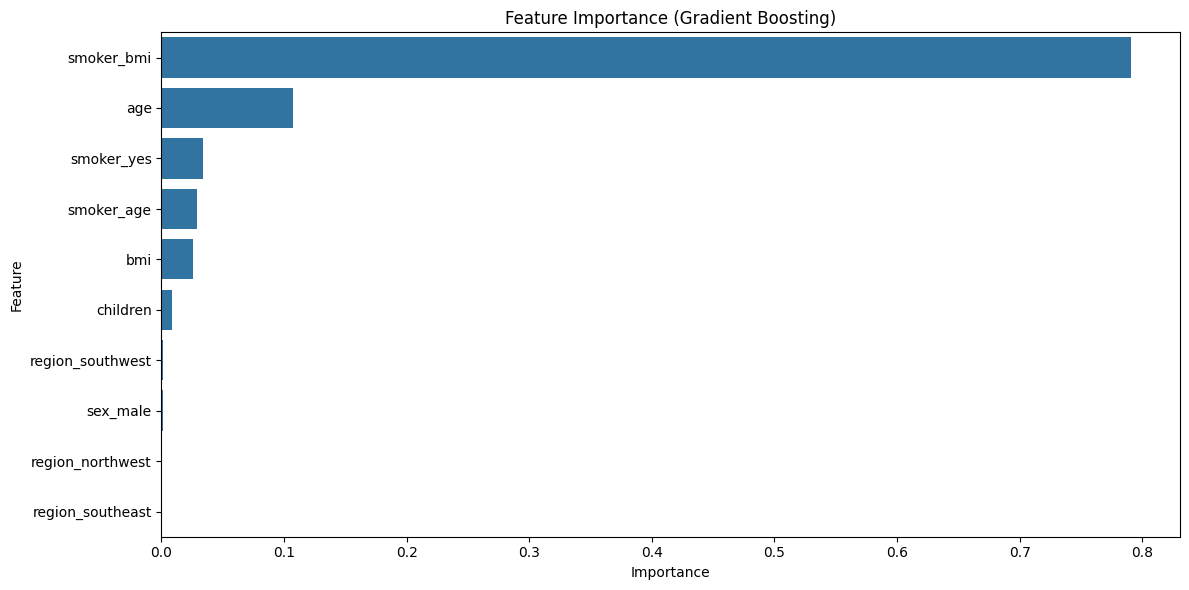

In [ ]:
best_model_pipeline = gb_pipeline  #gradient boosting apresentou os melhores resultados

best_model = best_model_pipeline.named_steps['model']

preprocessor = best_model_pipeline.named_steps['preprocessor']
cat_features = preprocessor.transformers_[1][1].get_feature_names_out(categorical_cols)
all_features = numerical_cols + list(cat_features)

if hasattr(best_model, 'feature_importances_'):
    feature_importances = best_model.feature_importances_
    importance_df = pd.DataFrame({
        'Feature': all_features,
        'Importance': feature_importances
    }).sort_values('Importance', ascending=False)
    plt.figure(figsize=(12, 6))
    sns.barplot(x='Importance', y='Feature', data=importance_df)
    plt.title('Feature Importance (Gradient Boosting)')
    plt.tight_layout()
    plt.show()
else:
    X_processed = preprocessor.transform(X_test)
    perm_importance = permutation_importance(best_model, X_processed, y_test, random_state=42)
    importance_df = pd.DataFrame({
        'Feature': all_features,
        'Importância': perm_importance.importances_mean
    }).sort_values('Importância', ascending=False)
    plt.figure(figsize=(12, 6))
    sns.barplot(x='Importance', y='Feature', data=importance_df)
    plt.title('Importância de Feature (Gradient Boosting)')
    plt.tight_layout()
    plt.show()

Como apresentado, a feature criada de bmi mapeada pelo status do fumante foi a feature com mais peso nas observações, justificando sua criação para o treinamento do modelo. Por outro lado, vemos que a região do paciente e seu sexo não possuem tanta influência como imaginado neste dataset. A remoção dessas features não afetaria tanto o resultado final do modelo, o que poderia ser considerado principalmente para datasets com mais entradas.

In [ ]:
# ## Customer Segmentation with K-Means
# K-Means Clustering for Risk Groups

## Clusterização de Pacientes utilizando K-Means

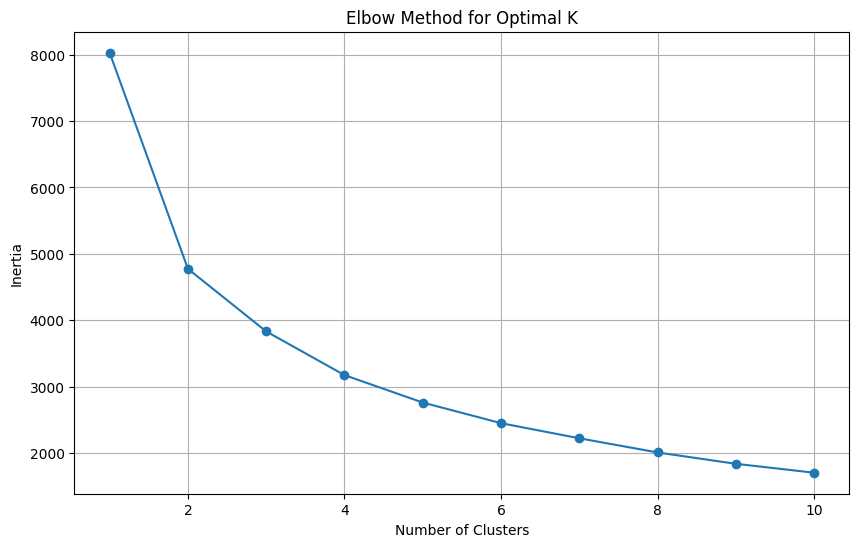

In [ ]:

# Features selecionadas
cluster_data = df_model[['age', 'bmi', 'children', 'charges', 'smoker_bmi', 'smoker_age']].copy()

# Normalização
scaler = StandardScaler()
scaled_data = scaler.fit_transform(cluster_data)

# Gráfico elbow para seleção do número ótimo de features
inertia = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(scaled_data)
    inertia.append(kmeans.inertia_)

plt.figure(figsize=(10, 6))
plt.plot(range(1, 11), inertia, marker='o')
plt.title('Elbow Method for Optimal K')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.grid(True)
plt.show()

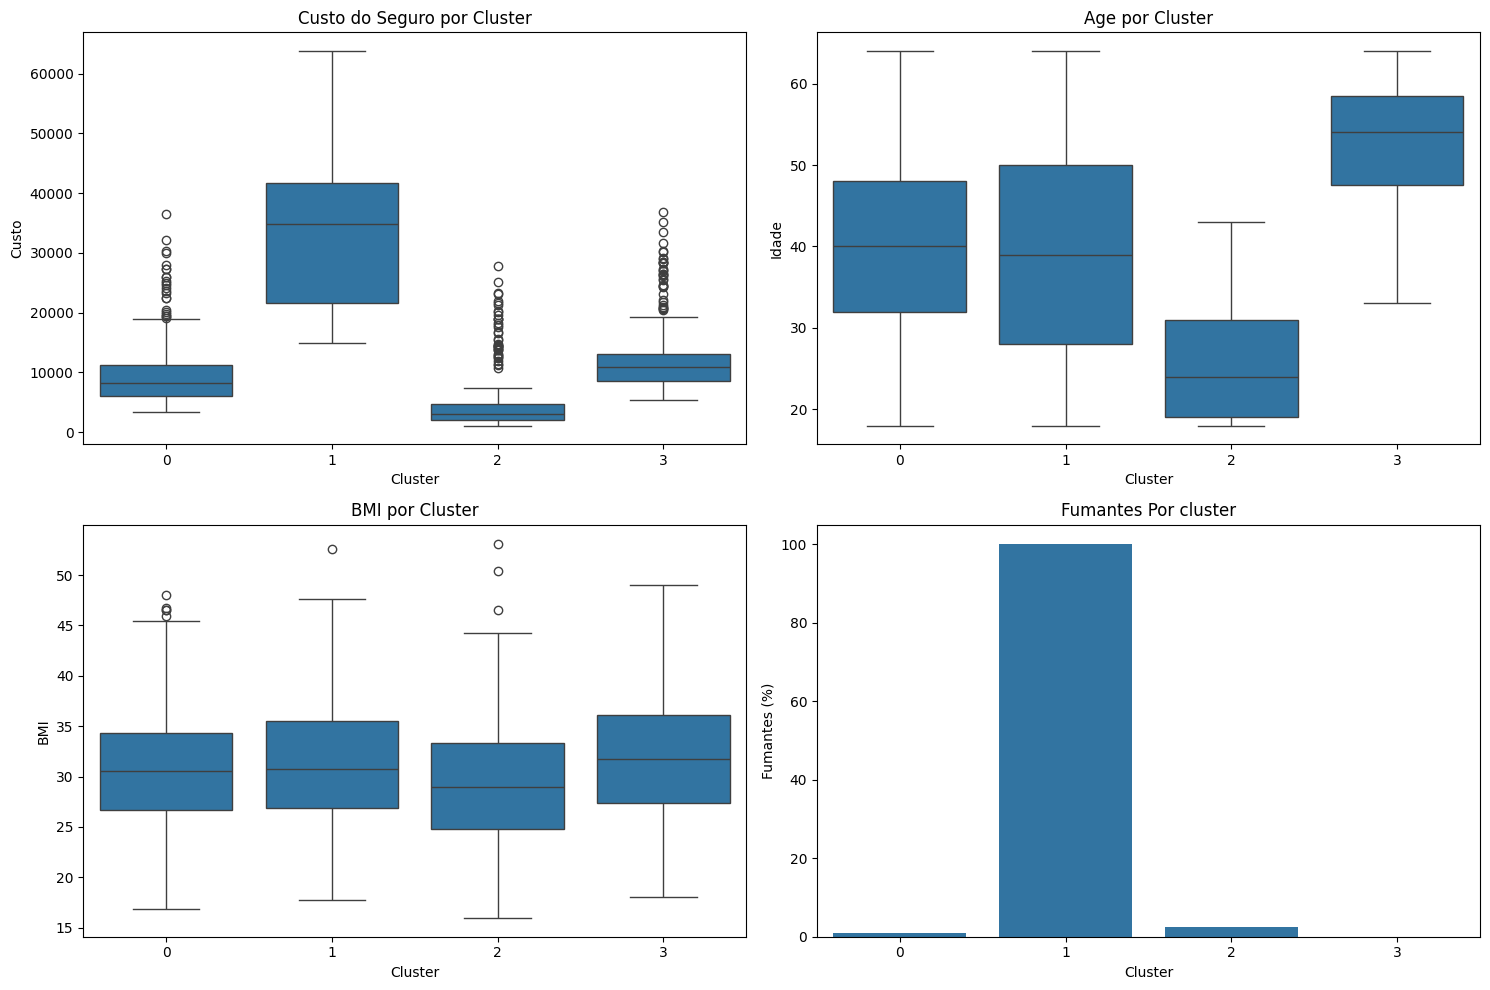

In [ ]:
# escolhemos K=4
optimal_k = 4
kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
cluster_labels = kmeans.fit_predict(scaled_data)

df_model['risk_cluster'] = cluster_labels

# Visualização dos clusters
plt.figure(figsize=(15, 10))

plt.subplot(2, 2, 1)
sns.boxplot(x='risk_cluster', y='charges', data=df_model)
plt.title('Custo do Seguro por Cluster')
plt.xlabel('Cluster')
plt.ylabel('Custo')

plt.subplot(2, 2, 2)
sns.boxplot(x='risk_cluster', y='age', data=df_model)
plt.title('Age por Cluster')
plt.xlabel('Cluster')
plt.ylabel('Idade')

plt.subplot(2, 2, 3)
sns.boxplot(x='risk_cluster', y='bmi', data=df_model)
plt.title('BMI por Cluster')
plt.xlabel('Cluster')
plt.ylabel('BMI')

plt.subplot(2, 2, 4)
smoker_cluster = df_model.groupby('risk_cluster')['smoker'].apply(lambda x: (x == 'yes').mean() * 100)
sns.barplot(x=smoker_cluster.index, y=smoker_cluster.values)
plt.title('Fumantes Por cluster')
plt.xlabel('Cluster')
plt.ylabel('Fumantes (%)')

plt.tight_layout()
plt.show()

Analisando os resultados, conseguimos traçar um perfil de cliente para cada um dos clusters:
- O cluster número 2 engloba clientes mais novos, com idades de até 30 anos e que não fumam. Esse é o grupo que possui custos de plano de saúde mais baixos -> Risco Baixo
- O cluster número 0 engloba clientes com uma faixa etária média (entre 30 e 50 anos) e não fumantes. É o que possui a segunda faixa mais barata de planos de saúde -> Risco Média
- O cluster número 3 engloba clientes mais velhos, também que não fumam, pagando, em média, um pouco mais caro do que os clientes dos clusters anteriores -> Risco Alto
- O cluster número 1 contém praticamente todos os clientes fumantes do dataset. Esse fator por sí só garante os preços mais altos de plano de saúde para este grupo -> Risco muito alto

Vemos também que o BMI não é um fator tão determinante na separação destes clusters, embora vemos que seus valores são ligeiramente mais altos para os grupos de fumantes e de clientes mais velhos.

## Categorização de Clientes com base nos Clusters definidos

In [ ]:
# Categorias de risco de clientes
risk_levels = {
    0: 'Low Risk',
    1: 'Medium Risk',
    2: 'High Risk',
    3: 'Very High Risk'
}

# Mapeamento dos grupos de risco em ordem do preço médio do plano
cluster_charges = df_model.groupby('risk_cluster')['charges'].mean().sort_values()
risk_mapping = {}
for i, cluster in enumerate(cluster_charges.index):
    risk_mapping[cluster] = list(risk_levels.values())[i]

df_model['risk_level'] = df_model['risk_cluster'].map(risk_mapping)

for cluster, level in risk_mapping.items():
    print(f"Cluster {cluster} -> {level}")

df_model['risk_level'].value_counts()

Cluster 2 -> Low Risk
Cluster 0 -> Medium Risk
Cluster 3 -> High Risk
Cluster 1 -> Very High Risk


,count
risk_level,
Low Risk,396
High Risk,375
Medium Risk,306
Very High Risk,261


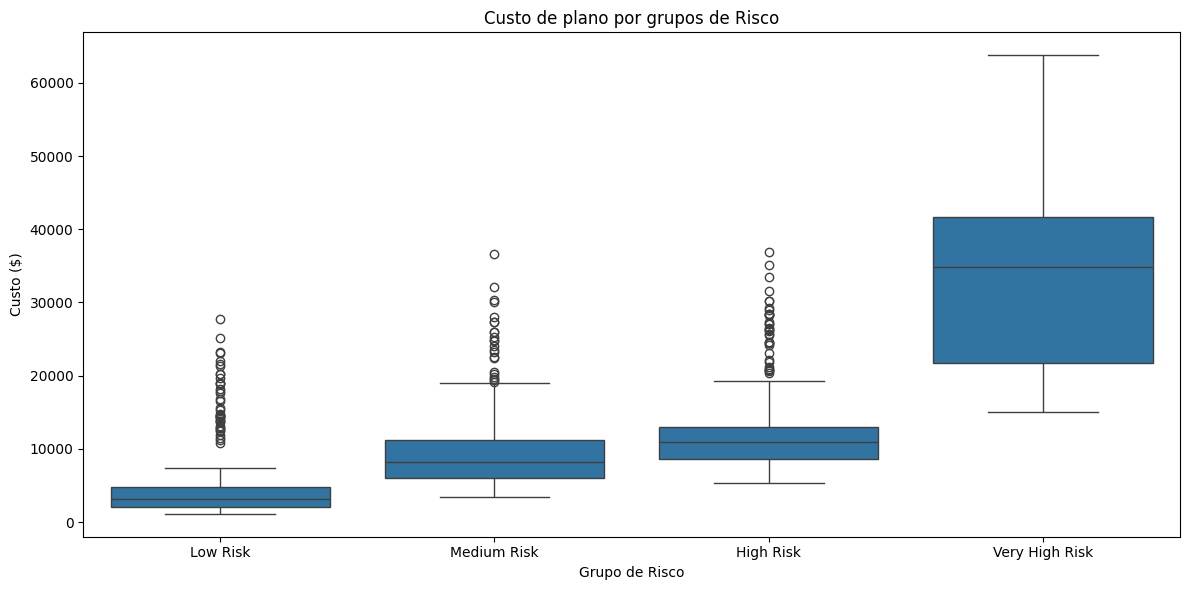

In [ ]:
# Custo de plano por grupos de Risco
plt.figure(figsize=(12, 6))
sns.boxplot(x='risk_level', y='charges', data=df_model, order=risk_levels.values())
plt.title('Custo de plano por grupos de Risco')
plt.xlabel('Grupo de Risco')
plt.ylabel('Custo ($)')
plt.tight_layout()
plt.show()

## Conclusão

A análise identificou os principais fatores que impactam os custos de seguros de saúde: o tabagismo é o mais influente, seguido por idade, IMC, número de dependentes. Região geográfica e gênero do cliente possuem um impacto mínimo no resultado. Os pacientes foram agrupados em perfis de risco (baixo, médio, alto e muito alto). O destaque é no escolha de um grupo composto por praticamente todos os fumantes, mostrando mais uma vez o impacto desta feature para o custo final do plano de saúde. O modelo de regressão Gradient Boosting se mostrou o mais eficaz para prever custos, e será utilizado por nosso sistema para predição clientes de risco e precificação preliminar de seus planos de saúde.

## Exportação dos Modelos

Os modelos de regressão Gradient Boosting e de Clusterização K-Means serão exportados para a API escrita em flask, para que o sistema seja acessível por outras frentes do projeto.

In [ ]:
# Export the Gradient Boosting model
import joblib
joblib.dump(gb_pipeline, 'gradient_boosting_model.pkl')

# Export the K-means model and scaler
joblib.dump(kmeans, 'kmeans_model.pkl')
joblib.dump(scaler, 'scaler.pkl')

# If needed, save the risk mapping
import json
with open('risk_mapping.json', 'w') as f:
    json.dump(risk_mapping, f)